In [1]:
#Imports
import sys
sys.path.append("../")
import numpy
import numpy.linalg
import os
import matplotlib
from tensorflow import keras
from classes import ModelWrapper, DataLoader, Cluster, Plotting

#Interactive matplotlib plots
%matplotlib widget

2024-05-03 10:53:55.023391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Parameters setting
eps = 1e-2
Cluster.active_zone_threshold = 0.7
Cluster.min_energy_density = 80
Cluster.min_length = 10
Cluster.max_nonlinearity = 1

In [3]:
#Create ensemble
track_type = "alltracks"
data_loader = DataLoader("../data")
noisy = data_loader.getBatch(True, True, track_type=track_type, normalising=True)
noisy_with_E = data_loader.getBatch(True, True, track_type=track_type, normalising=False)
clean = data_loader.getBatch(True,False, track_type=track_type)
names = data_loader.getX17Names(track_type)

modelAPI1 = ModelWrapper(keras.models.load_model("../models/3D/new_waveform"), "waveform")
modelAPI1.model.summary()

modelAPI2 = ModelWrapper(keras.models.load_model("../models/3D/small/model"), "spatial")
modelAPI2.model.summary()

rec1 = modelAPI1.evaluateBatch(noisy)
rec2 = modelAPI2.evaluateBatch(noisy)

cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')


2024-05-03 10:54:00.391403: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 14, 208, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 12, 14, 208, 5)    35        
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 14, 208, 5)    230       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 14, 104, 5)   0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 12, 14, 104, 5)    105       
                                                                 
 conv3d_3 (Conv3D)           (None, 12, 14, 104, 5)    230       
                                                             

In [4]:
combination = rec1*rec2
classified = numpy.where( combination > eps, combination, 0)

In [5]:
#Defragmentation
original_clusters_NN = []
defragmentation_coef = 0
cluster_count = 0

for i in range(classified.shape[0]):
	clusters_model_1 = Cluster.clusterise( numpy.where(rec1[i]>eps, 1, 0) )
	clusters_model_2 = Cluster.clusterise( numpy.where(rec2[i]>eps, 1, 0) )
	clusters_product = Cluster.clusterise(classified[i])
	cluster_count_before = len(clusters_product)

	clusters_product, _, _, _ = Cluster.defragment(clusters_product, clusters_model_1)
	#clusters_product, _, _, _ = Cluster.defragment(clusters_product, clusters_model_2)
	original_clusters_NN.append(clusters_product)
	defragmentation_coef += cluster_count_before - len(clusters_product)
	cluster_count += len(clusters_product)

print("Defragmentation occured", defragmentation_coef, "times (final number of clusters " + str(cluster_count) + ")")

Defragmentation occured 206 times (final number of clusters 613)


In [6]:
#Filter clusters based on length, energy density and zone tests
passing_clusters_NN = []
cluster_count = 0

for i in range(classified.shape[0]):
	current_passing_clusters = []
	for cluster in original_clusters_NN[i]:
		if cluster.length >= Cluster.min_length and cluster.testActiveZone():
			cluster.setEnergy(noisy_with_E[i])
			if cluster.energy_density >= Cluster.min_energy_density:
				current_passing_clusters.append(cluster)
	passing_clusters_NN.append(current_passing_clusters)
	cluster_count += len(current_passing_clusters)

clusters_NN = passing_clusters_NN
print("Current number of clusters after zone, L and E/L cuts is", cluster_count)

Current number of clusters after zone, L and E/L cuts is 306


In [7]:
def fitLine(cluster):
	data = numpy.array(cluster.coords, dtype=numpy.float64)
	mean = [numpy.mean(data[:,i]) for i in range(3)]

	#scaled_covariance_matrix = numpy.transpose(data) @ data
	#U, D, V = numpy.linalg.svd(scaled_covariance_matrix)

	#From SVD it follows that for data = UDV*, we have Var = data* data = VD*U* UDV* = VD^2 V*, so the right factor of @data and @scaled_covariance_matrix is the same
	_, _, V = numpy.linalg.svd(data - mean)
	direction = V[0]

	a, b = numpy.min(data[:,2]), numpy.max(data[:,2])

	t1, t2 = (a-mean[2]) / direction[2], (b-mean[2]) / direction[2]
	return (mean + t1*direction, mean + t2*direction, mean, direction)

In [8]:
def getTotalResiduum(cluster, line_direction, line_mean):
	residuum = 0
	data = numpy.array(cluster.coords, dtype=numpy.float64) - line_mean
	for i in range(data.shape[0]):
		coord = data[i]
		residuum += numpy.sqrt( coord[0]**2 + coord[1]**2 + coord[2]**2 - (coord[0]*line_direction[0] + coord[1]*line_direction[1] + coord[2]*line_direction[2])**2 + 1e-8)
	return residuum

In [9]:
#Apply linearity cut
passing_clusters_NN = []
cluster_count = 0

for i in range(classified.shape[0]):
	current_passing_clusters = []
	for cluster in clusters_NN[i]:
		line_start, line_end, line_mean, line_direction = fitLine(cluster)
		total_residuum = getTotalResiduum(cluster, line_direction, line_mean)
		cluster.nonlinearity = total_residuum / cluster.length

		if total_residuum / cluster.length < Cluster.max_nonlinearity:
				current_passing_clusters.append(cluster)
	passing_clusters_NN.append(current_passing_clusters)
	cluster_count += len(current_passing_clusters)

clusters_NN = passing_clusters_NN
print("Final number of clusters after linearity cut is", cluster_count)

Final number of clusters after linearity cut is 287


In [10]:
#Run the same prodecure for nonNN
clusters_nonNN = []
cluster_count = 0

for i in range(classified.shape[0]):
	clusters = Cluster.clusterise(clean[i])
	clusters_nonNN.append(clusters)
	cluster_count += len(clusters)

print("nonNN number of clusters", cluster_count)

passing_clusters_nonNN = []
cluster_count = 0
for i in range(classified.shape[0]):
	current_passing_clusters = []
	for cluster in clusters_nonNN[i]:
		if cluster.length >= Cluster.min_length and cluster.testActiveZone():
			cluster.setEnergy(noisy_with_E[i])
			if cluster.energy_density >= Cluster.min_energy_density:
				current_passing_clusters.append(cluster)
	passing_clusters_nonNN.append(current_passing_clusters)
	cluster_count += len(current_passing_clusters)

clusters_nonNN = passing_clusters_nonNN
print("nonNN current number of clusters after zone, L and E/L cuts is", cluster_count)

passing_clusters_nonNN = []
cluster_count = 0
for i in range(classified.shape[0]):
	current_passing_clusters = []
	for cluster in clusters_nonNN[i]:
		line_start, line_end, line_mean, line_direction = fitLine(cluster)
		total_residuum = getTotalResiduum(cluster, line_direction, line_mean)
		cluster.nonlinearity = total_residuum / cluster.length
		
		if total_residuum / cluster.length < Cluster.max_nonlinearity:
				current_passing_clusters.append(cluster)
	passing_clusters_nonNN.append(current_passing_clusters)
	cluster_count += len(current_passing_clusters)

clusters_nonNN = passing_clusters_nonNN
print("Final number of clusters after linearity cut is", cluster_count)

nonNN number of clusters 815
nonNN current number of clusters after zone, L and E/L cuts is 335
Final number of clusters after linearity cut is 329


/home/gajdoma6/UTEF/track_denoiser/notebooks/../classes.py:237: RuntimeWarning: invalid value encountered in double_scalars
  self.energy_density = self.energy / self.effective_length


In [11]:
def madeUpClusterTiles(cluster, noisy_event):
	count = 0
	for coord in cluster.coords:
		if noisy_event[coord] == 0:	count += 1
	return count

In [12]:
def missingClusterTiles(cluster, noisy_event):
	count = 0
	noisy_clusters = Cluster.clusterise(noisy_event)
	subsets1of2, subsets2of1 = Cluster.crossconnectClusters( [cluster], noisy_clusters )
	#print(subsets1of2)
	#print(subsets2of1)
	if subsets1of2[0] is not None:
		index = subsets1of2[0]
		for coord in noisy_clusters[index].coords:
			if coord not in cluster.coords:	count += 1
		subsets2of1[index] = None
	
	for i in range(len(noisy_clusters)):
		if subsets2of1[i] is not None:
			for coord in noisy_clusters[i].coords:
				if coord not in cluster.coords:	count += 1
	return count


In [13]:
def falsePositives(clusters, noisy_event):
	count = 0
	for cluster in clusters:
		if madeUpClusterTiles(cluster, noisy_event) / cluster.length > 0.5:
			count += 1
	return count

In [16]:
#Compare NN and nonNN numbers

defrag_NN, defrag_nonNN = [], []
for i in range(classified.shape[0]):
	curr_defrag_NN, curr_defrag_nonNN, _, _ = Cluster.defragment(clusters_NN[i], clusters_nonNN[i])
	defrag_NN.append(curr_defrag_NN)
	defrag_nonNN.append(curr_defrag_nonNN)

#Filter events which have more than two clusters
only_one_in_event_NN = {}
only_one_in_event_nonNN = {}
more_good_in_event_NN = {}
more_good_in_event_nonNN = {}

for i in range(len(clusters_NN)):
	if len(clusters_NN[i]) == 1:
		only_one_in_event_NN[i] = clusters_NN[i][0]
	elif len(clusters_NN[i]) >= 2:
		more_good_in_event_NN[i] = clusters_NN[i]

for i in range(len(clusters_nonNN)):
	if len(clusters_nonNN[i]) == 1:
		only_one_in_event_nonNN[i] = clusters_nonNN[i][0]
	elif len(clusters_nonNN[i]) >= 2:
		more_good_in_event_nonNN[i] = clusters_nonNN[i]


defrag_NN_num = sum(len(c) for c in defrag_NN)
defrag_nonNN_num = sum(len(c) for c in defrag_nonNN)
NN_num = sum(len(c) for c in clusters_NN)
nonNN_num = sum(len(c) for c in clusters_nonNN) 

print("NN fragmentation number:", NN_num - defrag_NN_num)
print("nonNN fragmentation number:", nonNN_num - defrag_nonNN_num)
#print("NN cluster number:", defrag_NN_num)
#print("nonNN cluster number:", defrag_nonNN_num)
print("NN good event number (with only one cluster):", len(only_one_in_event_NN))
print("nonNN good event number (with only one cluster):", len(only_one_in_event_nonNN))
print("NN count of events with more good clusters (without defragmentation):", sum(1 for clusters in clusters_NN if len(clusters) != 0) - len(only_one_in_event_NN))
print("nonNN count of events with more good clusters (without defragmentation):", sum(1 for clusters in clusters_nonNN if len(clusters) != 0) - len(only_one_in_event_nonNN))

#Made up tiles
'''print("NN made up tiles:", sum( madeUpClusterTiles(cluster, noisy[i]) for i in range(classified.shape[0]) for cluster in clusters_NN[i] ) )
print("nonNN made up tiles:", sum( madeUpClusterTiles(cluster, noisy[i]) for i in range(classified.shape[0]) for cluster in clusters_nonNN[i] ) )'''

#Missing tiles
print("NN missing tiles:", sum( missingClusterTiles(cluster, noisy[i]) for i in range(classified.shape[0]) for cluster in clusters_NN[i] ) )
print("nonNN missing tiles:", sum( missingClusterTiles(cluster, noisy[i]) for i in range(classified.shape[0]) for cluster in clusters_nonNN[i] ) )

#False positives
'''print("NN made up clusters:", sum( falsePositives(defrag_NN[i], noisy[i]) for i in range(classified.shape[0]) ) )
print("nonNN made up clusters:", sum( falsePositives(defrag_nonNN[i], noisy[i]) for i in range(classified.shape[0]) ) )'''

NN fragmentation number: 0
nonNN fragmentation number: 36
NN good event number (with only one cluster): 224
nonNN good event number (with only one cluster): 169
NN count of events with more good clusters: 31
nonNN count of events with more good clusters: 76
NN missing tiles: 1952
nonNN missing tiles: 4953


'print("NN made up clusters:", sum( falsePositives(defrag_NN[i], noisy[i]) for i in range(classified.shape[0]) ) )\nprint("nonNN made up clusters:", sum( falsePositives(defrag_nonNN[i], noisy[i]) for i in range(classified.shape[0]) ) )'

In [136]:
#Dump reconstructed events

data = []
for i in range(classified.shape[0]):
	event = numpy.zeros((12,14,208))
	for cluster in defrag_NN[i]:
		event += cluster.getTensor()
	data.append(event)

data_loader.dumpData(data, names, "reconstructed/NN/")

data = []
for i in range(classified.shape[0]):
	event = numpy.zeros((12,14,208))
	for cluster in defrag_nonNN[i]:
		event += cluster.getTensor()
	data.append(event)

data_loader.dumpData(data, names, "reconstructed/nonNN/")

In [81]:
#Noisy good clusters
clusters_noisy = []
cluster_count = 0
event_count = 0

for i in range(classified.shape[0]):
	clusters = Cluster.clusterise(noisy[i])
	clusters, _, _, _ = Cluster.defragment(clusters, original_clusters_NN[i])
	clusters_noisy.append(clusters)
	cluster_count += len(clusters)
	event_count += 1 if len(clusters) != 0 else 0

print("Noisy number of clusters (after defragmentation)", cluster_count, "and events", event_count)

passing_clusters_noisy = []
cluster_count = 0
event_count = 0
for i in range(classified.shape[0]):
	current_passing_clusters = []
	for cluster in clusters_noisy[i]:
		if cluster.length >= Cluster.min_length and cluster.testActiveZone():
			cluster.setEnergy(noisy_with_E[i])
			if cluster.energy_density >= Cluster.min_energy_density:
				current_passing_clusters.append(cluster)
	passing_clusters_noisy.append(current_passing_clusters)
	cluster_count += len(current_passing_clusters)
	event_count += 1 if len(current_passing_clusters) != 0 else 0


clusters_noisy = passing_clusters_noisy
print("Noisy current number of clusters after zone, L and E/L cuts is", cluster_count, "and events", event_count)

passing_clusters_noisy = []
cluster_count = 0
event_count = 0
for i in range(classified.shape[0]):
	current_passing_clusters = []
	for cluster in clusters_noisy[i]:
		line_start, line_end, line_mean, line_direction = fitLine(cluster)
		total_residuum = getTotalResiduum(cluster, line_direction, line_mean)
		cluster.nonlinearity = total_residuum / cluster.length
		
		if total_residuum / cluster.length < Cluster.max_nonlinearity:
				current_passing_clusters.append(cluster)
	passing_clusters_noisy.append(current_passing_clusters)
	cluster_count += len(current_passing_clusters)
	event_count += 1 if len(current_passing_clusters) != 0 else 0

clusters_noisy = passing_clusters_noisy
print("Final number of clusters after linearity cut is", cluster_count, "and events", event_count)
print("Number of good events (with only one good cluster) is", sum(1 for clusters in clusters_noisy if len(clusters) == 1))
print("Number of events with more than one good cluster is", sum(1 for clusters in clusters_noisy if len(clusters) >= 2))

Noisy number of clusters (after defragmentation) 5766 and events 640
Noisy current number of clusters after zone, L and E/L cuts is 346 and events 269
Final number of clusters after linearity cut is 331 and events 260
Number of good events (with only one good cluster) is 198
Number of events with more than one good cluster is 62


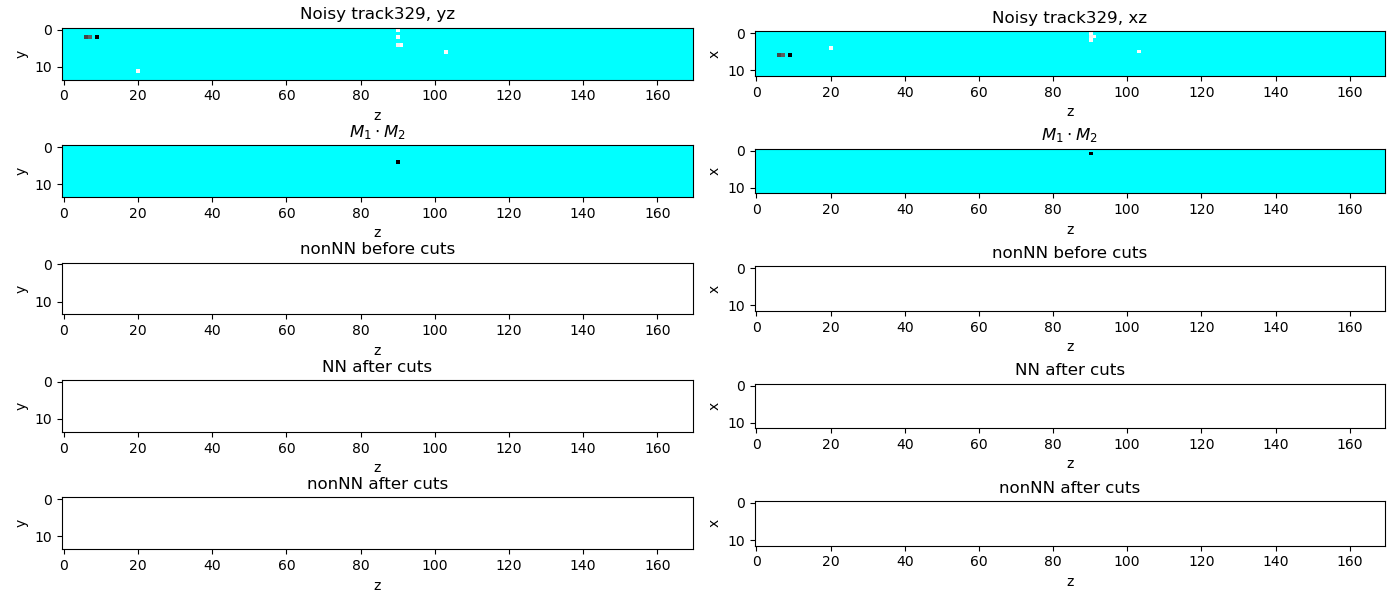

In [18]:
#Compare NN and nonNN

index = numpy.random.randint(noisy.shape[0])

'''while True:
	index = numpy.random.randint(noisy.shape[0])
	if falsePositives(clusters_NN[index], noisy[index]) != 0 or falsePositives(clusters_nonNN[index], noisy[index]) != 0:	break'''

reconstructed_event_NN = numpy.sum( [numpy.zeros((12,14,208))] + [ cluster.getTensor() for cluster in clusters_NN[index] ], 0)
reconstructed_event_nonNN = numpy.sum([numpy.zeros((12,14,208))] + [ cluster.getTensor() for cluster in clusters_nonNN[index] ], 0)

for cluster in original_clusters_NN[index]:
	cluster.setEnergy(noisy_with_E[index])
	_,_,mean,direction = fitLine(cluster)
	cluster.nonlinearity = getTotalResiduum(cluster, direction, mean) / cluster.length
	print("E/L =", cluster.energy_density, "  L =", cluster.length, "  nonlin =", cluster.nonlinearity, "  zone =", cluster.testActiveZone())
	print("Missing =", missingClusterTiles(cluster, noisy[index]), " ( relative", round(missingClusterTiles(cluster, noisy[index])/cluster.length, 3), 
		")   made up =", madeUpClusterTiles(cluster, noisy[index]), "( relative", round(madeUpClusterTiles(cluster, noisy[index])/cluster.length, 3), ")")

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(5,2)
for axis in [0,1]:
	ax[0,axis].imshow(numpy.sum(noisy_with_E[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(noisy[index])])/2)
	ax[0,axis].set_title("Noisy " + names[index] + (", yz" if axis == 0 else ", xz"))

	ax[1,axis].imshow(numpy.sum(combination[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(combination[index])])/2)
	ax[1,axis].set_title(r"$M_{1} \cdot M_{2}$")

	ax[2,axis].imshow(numpy.sum(clean[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(clean[index])])/2)
	ax[2,axis].set_title(r"nonNN before cuts")

	ax[3,axis].imshow(numpy.sum(reconstructed_event_NN, axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event_NN)])/2)
	ax[3,axis].set_title(r"NN after cuts")

	ax[4,axis].imshow(numpy.sum(reconstructed_event_nonNN, axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event_nonNN)])/2)
	ax[4,axis].set_title("nonNN after cuts")

	for i in range(5):
		ax[i,axis].set_xlabel("z")
		ax[i,axis].set_ylabel("y" if axis == 0 else "x")


for i in range(len(clusters_NN[index])):	
	line_start, line_end, _, _ = fitLine(clusters_NN[index][i])
	ax[3,0].plot([line_start[2], line_end[2]], [line_start[1], line_end[1]], color="#FFFFFF", linewidth=1)
	ax[3,1].plot([line_start[2], line_end[2]], [line_start[0], line_end[0]], color="#FFFFFF", linewidth=1)
	
for i in range(len(clusters_nonNN[index])):	
	line_start, line_end, _, _ = fitLine(clusters_nonNN[index][i])
	ax[4,0].plot([line_start[2], line_end[2]], [line_start[1], line_end[1]], color="#FFFFFF", linewidth=1)
	ax[4,1].plot([line_start[2], line_end[2]], [line_start[0], line_end[0]], color="#FFFFFF", linewidth=1)

fig.set_size_inches(14, 6)
fig.tight_layout()
matplotlib.pyplot.show()

Relative residuum: 0.5033510836133854
Number of clusters left: 1


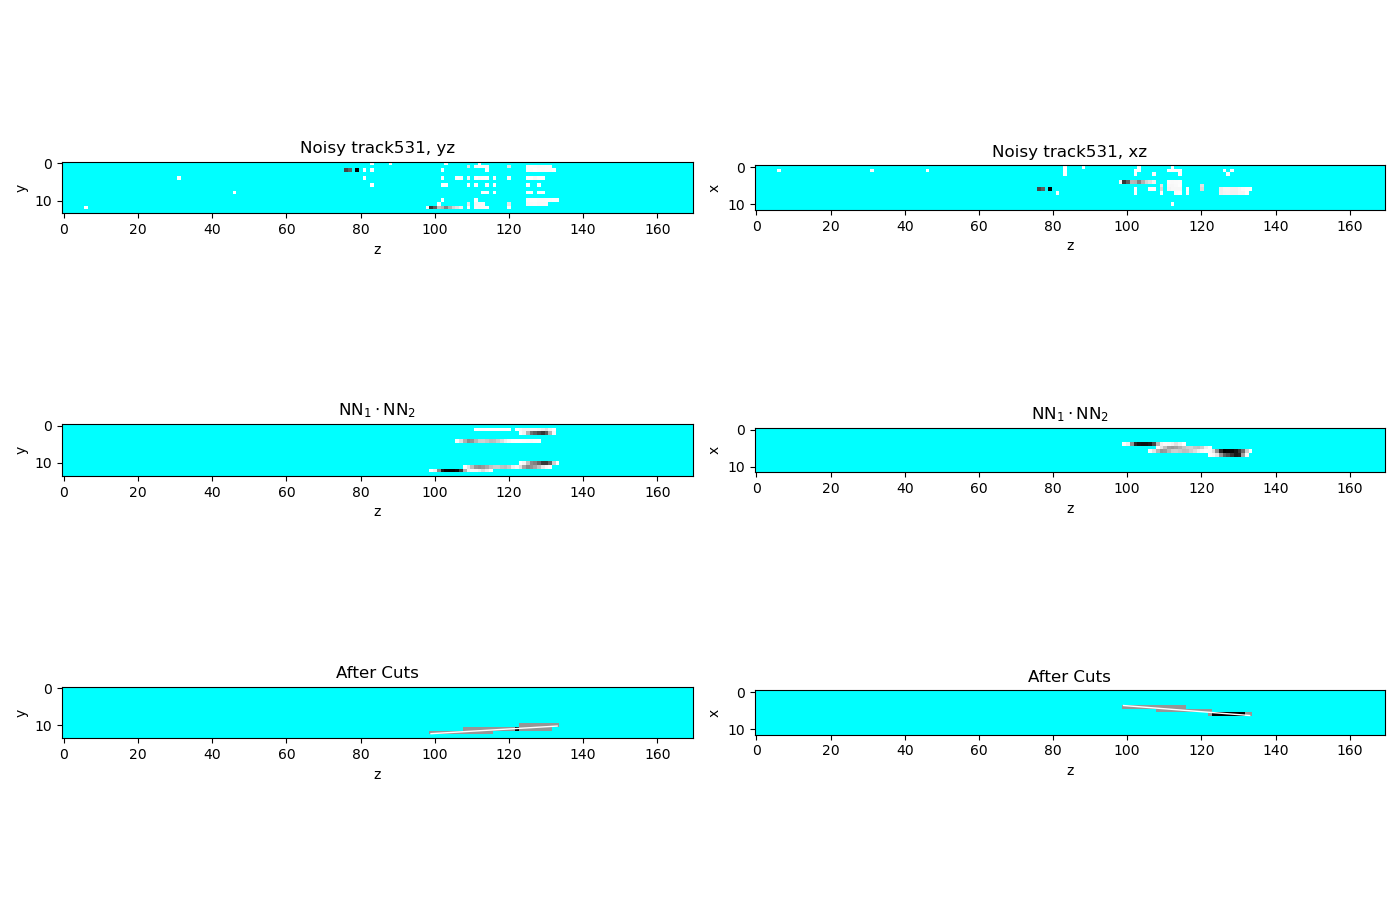

In [14]:
#Show with linear fit
clusters = clusters_NN

index = numpy.random.randint(noisy.shape[0])
while( len(clusters[index]) == 0):
	index = numpy.random.randint(noisy.shape[0])

reconstructed_event = numpy.sum([ cluster.getTensor() for cluster in clusters[index] ], 0)

line_start, line_end, line_mean, line_direction = fitLine(clusters[index][0])

total_residuum = getTotalResiduum(clusters[index][0], line_direction, line_mean)
print("Relative residuum:", total_residuum / clusters[index][0].length)

#PCA, noisy, without clusterisation
'''final = None
for cluster in Cluster.clusterise(noisy[index]):
	final = cluster if final == None else Cluster.union(cluster, final)
	#if cluster.length > 8:	break
line_start, line_end = fitLine(final)'''

#PCA, noisy, with clusterisation
'''for cluster in Cluster.clusterise(noisy[index]):
	if cluster.length > 8:	break
line_start, line_end = fitLine(cluster)'''

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(3,2)
for axis in [0,1]:
	ax[0,axis].imshow(numpy.sum(noisy[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(noisy[index])])/2)
	ax[0,axis].set_title("Noisy " + names[index] + (", yz" if axis == 0 else ", xz"))

	ax[1,axis].imshow(numpy.sum(rec1[index]*rec2[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event)])/2)
	ax[1,axis].set_title(r"$\text{NN}_1 \cdot \text{NN}_2$")

	ax[2,axis].imshow(numpy.sum(reconstructed_event, axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event)])/2)
	ax[2,axis].set_title("After Cuts")

	for i in range(3):
		ax[i,axis].set_xlabel("z")
		ax[i,axis].set_ylabel("y" if axis == 0 else "x")

ax[2,0].plot([line_start[2], line_end[2]], [line_start[1], line_end[1]], color="#FFFFFF", linewidth=1)
ax[2,1].plot([line_start[2], line_end[2]], [line_start[0], line_end[0]], color="#FFFFFF", linewidth=1)

print("Number of clusters left:", len(clusters_NN[index]))
fig.set_size_inches(14, 9)
fig.tight_layout()
matplotlib.pyplot.show()

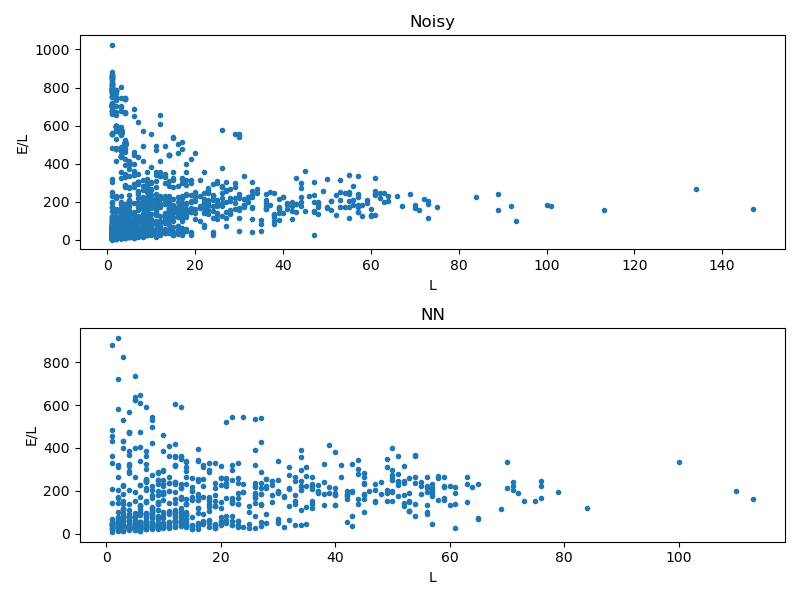

In [21]:
#2D scatter cuts parameters
paramX = lambda cluster:	cluster.length
paramY = lambda cluster:	cluster.energy_density
name_x = "L"
name_y = "E/L"

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)
fig, ax = matplotlib.pyplot.subplots(2)

data = [noisy, classified]
for axis in range(2):
	xs = []
	ys = []
	for i in range(classified.shape[0]):
		for cluster in Cluster.clusterise(data[axis][i]):
			cluster.setEnergy(noisy_with_E[i])
			xs.append(paramX(cluster))
			ys.append(paramY(cluster))

	ax[axis].scatter(xs, ys, marker=".")
	ax[axis].set_title("Noisy" if axis == 0 else "NN")
	ax[axis].set_xlabel(name_x)
	ax[axis].set_ylabel(name_y)

fig.set_size_inches(8, 6)
fig.tight_layout()
matplotlib.pyplot.show()

NN: 1   nonNN: 2


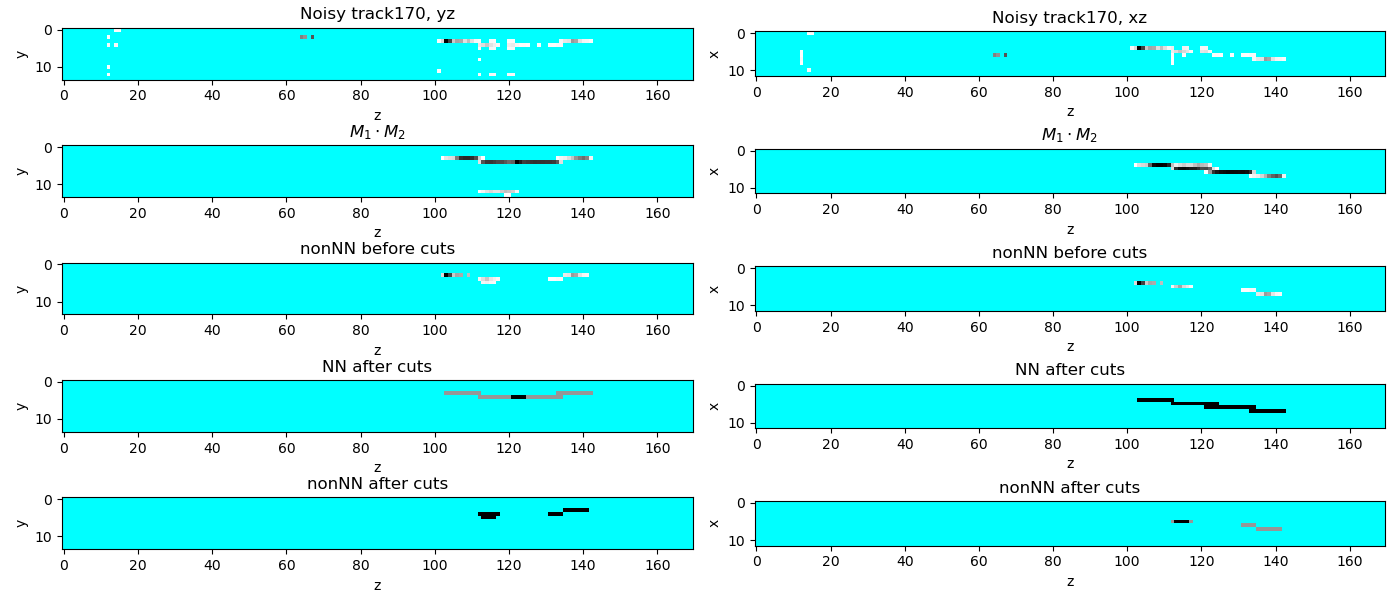

In [117]:
#Show events with multiple good clusters:

#index = numpy.random.choice(list(more_good_in_event_NN.keys()) + list(more_good_in_event_nonNN.keys()))
index = numpy.random.choice(list(only_one_in_event_NN.keys()) + list(only_one_in_event_nonNN.keys()))

reconstructed_event_NN = numpy.sum( [numpy.zeros((12,14,208))] + [ cluster.getTensor() for cluster in clusters_NN[index] ], 0)
reconstructed_event_nonNN = numpy.sum([numpy.zeros((12,14,208))] + [ cluster.getTensor() for cluster in clusters_nonNN[index] ], 0)

print("NN:", len(defrag_NN[index]), "  nonNN:", len(defrag_nonNN[index]))

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(5,2)
for axis in [0,1]:
	ax[0,axis].imshow(numpy.sum(noisy_with_E[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(noisy[index])])/2)
	ax[0,axis].set_title("Noisy " + names[index] + (", yz" if axis == 0 else ", xz"))

	ax[1,axis].imshow(numpy.sum(combination[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(combination[index])])/2)
	ax[1,axis].set_title(r"$M_{1} \cdot M_{2}$")

	ax[2,axis].imshow(numpy.sum(clean[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(clean[index])])/2)
	ax[2,axis].set_title(r"nonNN before cuts")

	ax[3,axis].imshow(numpy.sum(reconstructed_event_NN, axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event_NN)])/2)
	ax[3,axis].set_title(r"NN after cuts")

	ax[4,axis].imshow(numpy.sum(reconstructed_event_nonNN, axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event_nonNN)])/2)
	ax[4,axis].set_title("nonNN after cuts")

	for i in range(5):
		ax[i,axis].set_xlabel("z")
		ax[i,axis].set_ylabel("y" if axis == 0 else "x")

fig.set_size_inches(14, 6)
fig.tight_layout()
matplotlib.pyplot.show()

Noisy:
E/L = 555.6   L = 10   nonlin = 0.00010000001887725813   zone = True
Missing = 0  ( relative 0.0 )   made up = 0 ( relative 0.0 )
E/L = 148.5   L = 16   nonlin = 0.3002103260228732   zone = True
Missing = 0  ( relative 0.0 )   made up = 0 ( relative 0.0 )
E/L = 138.8   L = 15   nonlin = 0.3630143079908944   zone = True
Missing = 0  ( relative 0.0 )   made up = 0 ( relative 0.0 )
-----------------------------
NN:
E/L = 157.0   L = 16   nonlin = 0.3154853975497893   zone = True
Missing = 1  ( relative 0.062 )   made up = 1 ( relative 0.062 )
E/L = 79.0   L = 4   nonlin = 9.999999639177505e-05   zone = True
Missing = 0  ( relative 0.0 )   made up = 3 ( relative 0.75 )
E/L = 127.64285714285714   L = 19   nonlin = 0.4107331019179048   zone = True
Missing = 1  ( relative 0.053 )   made up = 5 ( relative 0.263 )
E/L = 881.0   L = 1   nonlin = 0.0001   zone = True
Missing = 9  ( relative 9.0 )   made up = 0 ( relative 0.0 )


/tmp/ipykernel_7993/2178075302.py:14: RuntimeWarning: invalid value encountered in double_scalars
  t1, t2 = (a-mean[2]) / direction[2], (b-mean[2]) / direction[2]


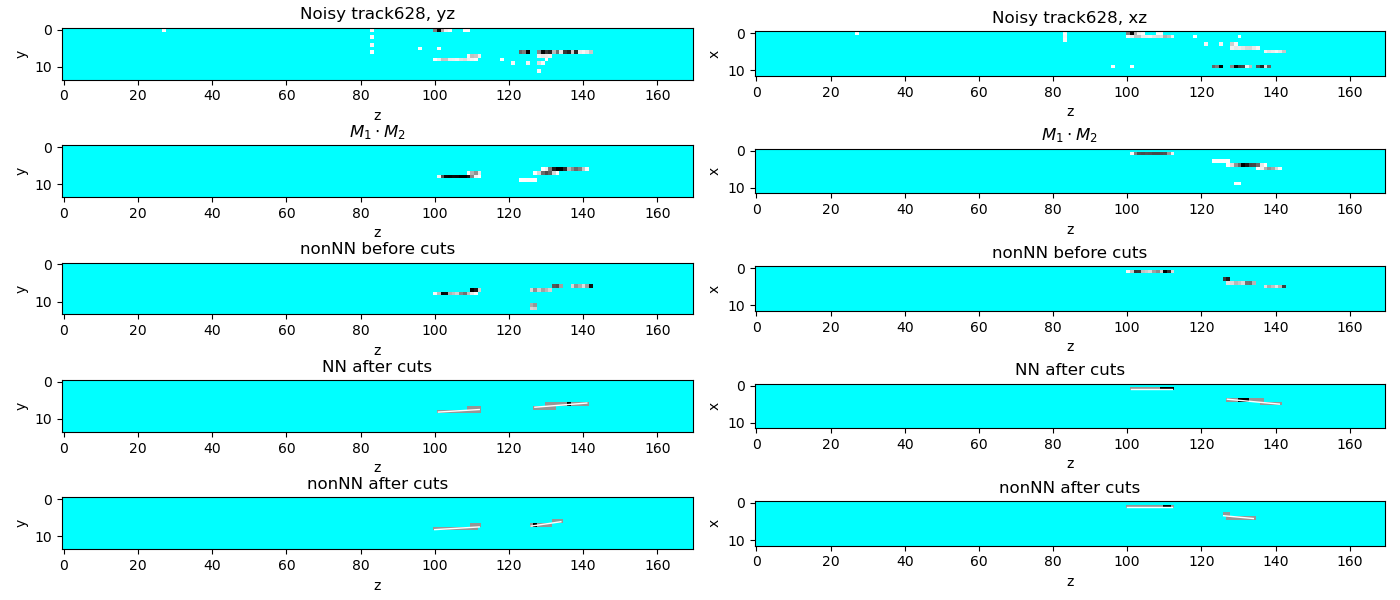

No such comm: 424d787531a24a819c919b183547521a
No such comm: 424d787531a24a819c919b183547521a


In [23]:
#Show events with good track not found:

while True:
	index = numpy.random.randint(noisy.shape[0])
	if len(clusters_noisy[index]) > len(clusters_NN[index]):	break

reconstructed_event_NN = numpy.sum( [numpy.zeros((12,14,208))] + [ cluster.getTensor() for cluster in clusters_NN[index] ], 0)
reconstructed_event_nonNN = numpy.sum([numpy.zeros((12,14,208))] + [ cluster.getTensor() for cluster in clusters_nonNN[index] ], 0)

print("Noisy:")
for cluster in clusters_noisy[index]:
	cluster.setEnergy(noisy_with_E[index])
	_,_,mean,direction = fitLine(cluster)
	cluster.nonlinearity = getTotalResiduum(cluster, direction, mean) / cluster.length
	print("E/L =", cluster.energy_density, "  L =", cluster.length, "  nonlin =", cluster.nonlinearity, "  zone =", cluster.testActiveZone())
	print("Missing =", missingClusterTiles(cluster, noisy[index]), " ( relative", round(missingClusterTiles(cluster, noisy[index])/cluster.length, 3), 
		")   made up =", madeUpClusterTiles(cluster, noisy[index]), "( relative", round(madeUpClusterTiles(cluster, noisy[index])/cluster.length, 3), ")")
	
print("-----------------------------")
print("NN:")
for cluster in original_clusters_NN[index]:
	cluster.setEnergy(noisy_with_E[index])
	_,_,mean,direction = fitLine(cluster)
	cluster.nonlinearity = getTotalResiduum(cluster, direction, mean) / cluster.length
	print("E/L =", cluster.energy_density, "  L =", cluster.length, "  nonlin =", cluster.nonlinearity, "  zone =", cluster.testActiveZone())
	print("Missing =", missingClusterTiles(cluster, noisy[index]), " ( relative", round(missingClusterTiles(cluster, noisy[index])/cluster.length, 3), 
		")   made up =", madeUpClusterTiles(cluster, noisy[index]), "( relative", round(madeUpClusterTiles(cluster, noisy[index])/cluster.length, 3), ")")

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(5,2)
for axis in [0,1]:
	ax[0,axis].imshow(numpy.sum(noisy_with_E[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(noisy[index])])/2)
	ax[0,axis].set_title("Noisy " + names[index] + (", yz" if axis == 0 else ", xz"))

	ax[1,axis].imshow(numpy.sum(combination[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(combination[index])])/2)
	ax[1,axis].set_title(r"$M_{1} \cdot M_{2}$")

	ax[2,axis].imshow(numpy.sum(clean[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(clean[index])])/2)
	ax[2,axis].set_title(r"nonNN before cuts")

	ax[3,axis].imshow(numpy.sum(reconstructed_event_NN, axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event_NN)])/2)
	ax[3,axis].set_title(r"NN after cuts")

	ax[4,axis].imshow(numpy.sum(reconstructed_event_nonNN, axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(reconstructed_event_nonNN)])/2)
	ax[4,axis].set_title("nonNN after cuts")

	for i in range(5):
		ax[i,axis].set_xlabel("z")
		ax[i,axis].set_ylabel("y" if axis == 0 else "x")


for i in range(len(clusters_NN[index])):	
	line_start, line_end, _, _ = fitLine(clusters_NN[index][i])
	ax[3,0].plot([line_start[2], line_end[2]], [line_start[1], line_end[1]], color="#FFFFFF", linewidth=1)
	ax[3,1].plot([line_start[2], line_end[2]], [line_start[0], line_end[0]], color="#FFFFFF", linewidth=1)
	
for i in range(len(clusters_nonNN[index])):	
	line_start, line_end, _, _ = fitLine(clusters_nonNN[index][i])
	ax[4,0].plot([line_start[2], line_end[2]], [line_start[1], line_end[1]], color="#FFFFFF", linewidth=1)
	ax[4,1].plot([line_start[2], line_end[2]], [line_start[0], line_end[0]], color="#FFFFFF", linewidth=1)

fig.set_size_inches(14, 6)
fig.tight_layout()
matplotlib.pyplot.show()

300.91826124945385


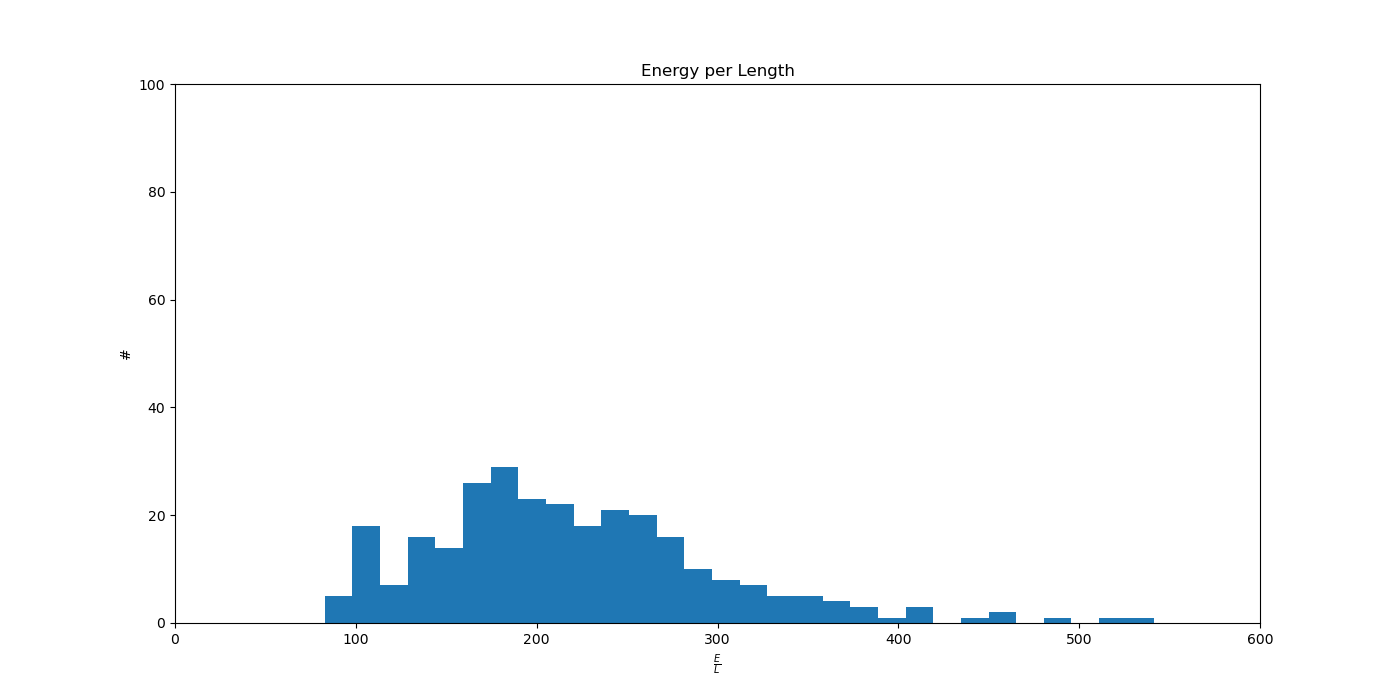

In [ ]:
#E/L plot

def getEnergies(clusters):
	energy_density = []
	energy = []

	for event_clusters in clusters:
		for cluster in event_clusters:
			energy_density.append(cluster.energy_density)
			for coord in cluster.coords:
				energy.append(noisy_with_E[i][coord])
	return (energy_density, energy)


cluster_densities, _ = getEnergies(clusters_NN)
fig, ax = matplotlib.pyplot.subplots(1)
bin_heights, bin_borders, _ = ax.hist(cluster_densities, 30, log=False, density=False)
ax.set_title("Energy per Length")
ax.set_xlabel(r"$\frac{E}{L}$")
ax.set_ylabel("#")
ax.set_ylim(0,100)
ax.set_xlim(0,600)
bin_centers = bin_borders[:-1] + numpy.diff(bin_borders) / 2
bin_heights, bin_centers = bin_heights[10:], bin_centers[10:]
print( sum(bin_heights*bin_centers) / sum(bin_heights) )
#print( sum(energy) / len(energy) )

fig.set_size_inches(14, 7)
matplotlib.pyplot.show()